## Multisource Model M2 - OpenFWI Unsupervised Framework Implementation (CurveVel)

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import deepwave

from pysit.gallery import marmousi
from pysit.gallery import marmousi2

import numpy as np
import torch
import torch.optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models.vgg as vgg
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from model import *

import seaborn as sns

from torchmetrics.functional import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

from tqdm.notebook import tqdm
from tqdm import tqdm

import scipy.ndimage

GPU = True
if GPU == True:
    torch.cuda.set_device(2)
    dtype = torch.cuda.FloatTensor
    device = torch.device('cuda:2')  
    torch.cuda.empty_cache()
    print("Total number of GPU available -",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

/home/naveengupta/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


Total number of GPU available - 8


# Loading Data: OpenFWI

In [3]:
amp1 = np.load('./CurveVel-A/amplitude/data1.npy')
amp2 = np.load('./CurveVel-A/amplitude/data2.npy')

vel1 = np.load('./CurveVel-A/velocity/model1.npy')
vel2 = np.load('./CurveVel-A/velocity/model2.npy')

# converting to torch tensor
amp1 = torch.tensor(amp1, device=device)
amp2 = torch.tensor(amp2, device=device)

vel1 = torch.tensor(vel1, device=device)
vel2 = torch.tensor(vel2, device=device)

total_amp_data = torch.cat((amp1, amp2), 0)
total_vel_data = torch.cat((vel1, vel2), 0)

In [4]:
# Custom Dataloader for autoencoders for enumerating using PyTorch dataloader
class AutoEncoderDataLoader(Dataset):

    def __init__(self, amps):
        self.amps = amps

    def __getitem__(self, index):
        return self.amps[index]
    
    def __len__(self):
        return len(self.amps)

In [5]:
amp_data = AutoEncoderDataLoader(total_amp_data)

train_size = int(len(amp_data)*0.8)
test_size = len(amp_data) - train_size

train_data, test_data = torch.utils.data.random_split(amp_data, [train_size, test_size])

trainloader = DataLoader(train_data, batch_size=25, shuffle=True)
testloader = DataLoader(test_data, batch_size=25, shuffle=False)

### Loading InversionNet Trained Model

In [3]:
input_channels = 5
encoder_channels = [32, 64, 64, 64, 64, 128, 128, 128, 128,
                   256, 256, 256, 256, 512]

decoder_channels = [512, 256, 128, 64, 32]

# checkpoint = torch.load('Checkpoints/CurveVel-A/InversionNet_optimizer_epoch_loss.pth')

net = InversionNetB(input_channels, encoder_channels, decoder_channels).to(device)
net.load_state_dict(torch.load('./Checkpoints/CurveVel-A/InversionNet_e_2000.pth'))
net.train()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

In [7]:
params = [p for p in net.parameters()]

l2_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()

c = 1
# c = 0.3
# 
optimizer = torch.optim.SGD([{'params':params, 'lr':1e-4}])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

### Seismic Acquisition Parameters

In [8]:
## Numbers are referred from the OpenFWI paper (OpenFWI: Large-Scale Multi-Structural Benchmark 
## Datasets for Seismic Full Waveform Inversion)

dx = 10
nz, ny = 70, 70

num_dims = 2
num_shots = 5

num_sources_per_shot = 1
source_spacing = 140

num_receivers_per_shot = 70
receiver_spacing = 10

peak_freq = 15
dt = 0.001 # 4ms

n_seconds = 1   # number of seconds receivers are recording
nt = int(n_seconds / dt) # number of time samples

In [9]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing

# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [10]:
# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
# This initial guess is shifted in frequency from the true one
source_amplitudes_init = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)


In [10]:
from torch.autograd import Variable

epochs = 1000
loss_curve = []

batch_amp_pred = torch.zeros((1000, 5, 70)).to(device)


for epoch in tqdm(range(epochs)):
    train_loss = 0
    for _, amp in enumerate(trainloader):
        optimizer.zero_grad()
        amp = amp.to(device)
        vel_pred = net(amp)
        
        for i in range(25):
            vel = vel_pred[i].squeeze()
            prop = deepwave.scalar.Propagator({'vp': vel}, dx)
            # print(vel)
            batch_amp_pred = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), 
                                    dt)
        
            batch_amp_pred = batch_amp_pred.permute(1, 0, 2)

            
            loss1 = l2_loss(amp[i], batch_amp_pred)
            train_loss += loss1.item()

        loss1.backward()
        # pixel_loss.backward()
        optimizer.step()
    
    train_loss /= len(trainloader)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{epochs}, Total Loss: {train_loss}")
    loss_curve.append(train_loss)
    
# t_end = time.time()

  0%|                                        | 1/1000 [00:17<4:54:46, 17.70s/it]

Epoch: 0/1000, Total Loss: 99.68906057626009


  1%|▍                                      | 11/1000 [03:17<4:59:01, 18.14s/it]

Epoch: 10/1000, Total Loss: 100.62347570061684


  2%|▊                                      | 21/1000 [06:20<4:58:53, 18.32s/it]

Epoch: 20/1000, Total Loss: 99.83388733118773


  3%|█▏                                     | 31/1000 [09:24<4:55:28, 18.30s/it]

Epoch: 30/1000, Total Loss: 99.7105348482728


  4%|█▌                                     | 41/1000 [12:26<4:50:59, 18.21s/it]

Epoch: 40/1000, Total Loss: 100.07901442795992


  5%|█▉                                     | 51/1000 [15:28<4:47:42, 18.19s/it]

Epoch: 50/1000, Total Loss: 99.98164488375187


  6%|██▍                                    | 61/1000 [18:30<4:45:23, 18.24s/it]

Epoch: 60/1000, Total Loss: 99.47615829855204


  7%|██▊                                    | 71/1000 [21:33<4:43:37, 18.32s/it]

Epoch: 70/1000, Total Loss: 100.01952552050352


  8%|███▏                                   | 81/1000 [24:36<4:40:18, 18.30s/it]

Epoch: 80/1000, Total Loss: 99.74219816923141


  9%|███▌                                   | 91/1000 [27:39<4:37:58, 18.35s/it]

Epoch: 90/1000, Total Loss: 99.39283563941717


 10%|███▊                                  | 101/1000 [30:42<4:34:58, 18.35s/it]

Epoch: 100/1000, Total Loss: 99.64791579544544


 11%|████▏                                 | 111/1000 [33:45<4:31:01, 18.29s/it]

Epoch: 110/1000, Total Loss: 99.81907656043768


 12%|████▌                                 | 121/1000 [36:47<4:27:24, 18.25s/it]

Epoch: 120/1000, Total Loss: 99.69202480465174


 13%|████▉                                 | 131/1000 [39:50<4:23:11, 18.17s/it]

Epoch: 130/1000, Total Loss: 99.60372010618448


 14%|█████▎                                | 141/1000 [42:51<4:19:39, 18.14s/it]

Epoch: 140/1000, Total Loss: 99.52480407804251


 15%|█████▋                                | 151/1000 [45:53<4:16:41, 18.14s/it]

Epoch: 150/1000, Total Loss: 99.32990255951881


 16%|██████                                | 161/1000 [48:55<4:14:54, 18.23s/it]

Epoch: 160/1000, Total Loss: 99.37835473567247


 17%|██████▍                               | 171/1000 [51:59<4:13:24, 18.34s/it]

Epoch: 170/1000, Total Loss: 99.43022708594799


 18%|██████▉                               | 181/1000 [55:01<4:08:27, 18.20s/it]

Epoch: 180/1000, Total Loss: 99.91878436505795


 19%|███████▎                              | 191/1000 [58:04<4:05:39, 18.22s/it]

Epoch: 190/1000, Total Loss: 99.10695790499449


 20%|███████▏                            | 201/1000 [1:01:06<4:02:40, 18.22s/it]

Epoch: 200/1000, Total Loss: 99.90176632255316


 21%|███████▌                            | 211/1000 [1:04:08<4:00:51, 18.32s/it]

Epoch: 210/1000, Total Loss: 99.5950729995966


 22%|███████▉                            | 221/1000 [1:08:05<5:20:52, 24.71s/it]

Epoch: 220/1000, Total Loss: 99.59554949402809


 23%|████████▎                           | 231/1000 [1:12:17<5:22:56, 25.20s/it]

Epoch: 230/1000, Total Loss: 99.70536875724792


 24%|████████▋                           | 241/1000 [1:16:05<4:31:25, 21.46s/it]

Epoch: 240/1000, Total Loss: 99.63614731281996


 25%|█████████                           | 251/1000 [1:19:37<4:22:36, 21.04s/it]

Epoch: 250/1000, Total Loss: 99.23627026379108


 26%|█████████▍                          | 261/1000 [1:23:06<4:17:13, 20.88s/it]

Epoch: 260/1000, Total Loss: 99.58068554103374


 27%|█████████▊                          | 271/1000 [1:26:33<4:10:07, 20.59s/it]

Epoch: 270/1000, Total Loss: 99.56810792535543


 28%|██████████                          | 281/1000 [1:30:04<4:11:48, 21.01s/it]

Epoch: 280/1000, Total Loss: 99.37282624095678


 29%|██████████▍                         | 291/1000 [1:33:32<4:08:55, 21.07s/it]

Epoch: 290/1000, Total Loss: 99.31344681233168


 30%|██████████▊                         | 301/1000 [1:37:04<4:04:19, 20.97s/it]

Epoch: 300/1000, Total Loss: 99.75892435014248


 31%|███████████▏                        | 311/1000 [1:40:29<3:56:51, 20.63s/it]

Epoch: 310/1000, Total Loss: 99.51280230283737


 32%|███████████▌                        | 321/1000 [1:44:00<3:57:23, 20.98s/it]

Epoch: 320/1000, Total Loss: 99.49740856140852


 33%|███████████▉                        | 331/1000 [1:47:29<3:53:56, 20.98s/it]

Epoch: 330/1000, Total Loss: 99.28085772693157


 34%|████████████▎                       | 341/1000 [1:50:57<3:49:38, 20.91s/it]

Epoch: 340/1000, Total Loss: 98.99801582843065


 35%|████████████▋                       | 351/1000 [1:54:28<3:49:21, 21.20s/it]

Epoch: 350/1000, Total Loss: 99.56555663794279


 36%|████████████▉                       | 361/1000 [1:57:56<3:40:45, 20.73s/it]

Epoch: 360/1000, Total Loss: 99.40704115480185


 37%|█████████████▎                      | 371/1000 [2:01:23<3:33:40, 20.38s/it]

Epoch: 370/1000, Total Loss: 99.52650059759617


 38%|█████████████▋                      | 381/1000 [2:04:55<3:41:16, 21.45s/it]

Epoch: 380/1000, Total Loss: 98.83807397633791


 39%|██████████████                      | 391/1000 [2:08:22<3:28:24, 20.53s/it]

Epoch: 390/1000, Total Loss: 99.38214980065823


 40%|██████████████▍                     | 401/1000 [2:11:52<3:25:37, 20.60s/it]

Epoch: 400/1000, Total Loss: 99.35546834021807


 41%|██████████████▊                     | 411/1000 [2:15:20<3:23:41, 20.75s/it]

Epoch: 410/1000, Total Loss: 99.23361265659332


 42%|███████████████▏                    | 421/1000 [2:18:49<3:21:31, 20.88s/it]

Epoch: 420/1000, Total Loss: 99.54427625238895


 43%|███████████████▌                    | 431/1000 [2:22:19<3:18:16, 20.91s/it]

Epoch: 430/1000, Total Loss: 99.33615189790726


 44%|███████████████▉                    | 441/1000 [2:25:47<3:11:06, 20.51s/it]

Epoch: 440/1000, Total Loss: 99.31813576072454


 45%|████████████████▏                   | 451/1000 [2:29:14<3:09:41, 20.73s/it]

Epoch: 450/1000, Total Loss: 99.10721715539694


 46%|████████████████▌                   | 461/1000 [2:32:43<3:06:46, 20.79s/it]

Epoch: 460/1000, Total Loss: 99.26527674496174


 47%|████████████████▉                   | 471/1000 [2:36:11<3:05:06, 21.00s/it]

Epoch: 470/1000, Total Loss: 99.32609146088362


 48%|█████████████████▎                  | 481/1000 [2:39:40<2:58:30, 20.64s/it]

Epoch: 480/1000, Total Loss: 99.36678227037191


 49%|█████████████████▋                  | 491/1000 [2:43:05<2:54:48, 20.61s/it]

Epoch: 490/1000, Total Loss: 99.54427450150251


 50%|██████████████████                  | 501/1000 [2:46:33<2:53:28, 20.86s/it]

Epoch: 500/1000, Total Loss: 99.24562206119299


 51%|██████████████████▍                 | 511/1000 [2:49:59<2:48:03, 20.62s/it]

Epoch: 510/1000, Total Loss: 98.80821514874697


 52%|██████████████████▊                 | 521/1000 [2:53:31<2:48:50, 21.15s/it]

Epoch: 520/1000, Total Loss: 99.24723532795906


 53%|███████████████████                 | 531/1000 [2:56:58<2:41:16, 20.63s/it]

Epoch: 530/1000, Total Loss: 99.12597739696503


 54%|███████████████████▍                | 541/1000 [3:00:26<2:38:44, 20.75s/it]

Epoch: 540/1000, Total Loss: 98.96209554374218


 55%|███████████████████▊                | 551/1000 [3:03:53<2:35:27, 20.77s/it]

Epoch: 550/1000, Total Loss: 99.21423812955618


 56%|████████████████████▏               | 561/1000 [3:07:23<2:32:27, 20.84s/it]

Epoch: 560/1000, Total Loss: 98.89273541420698


 57%|████████████████████▌               | 571/1000 [3:10:55<2:30:16, 21.02s/it]

Epoch: 570/1000, Total Loss: 98.94662530720234


 58%|████████████████████▉               | 581/1000 [3:14:26<2:27:12, 21.08s/it]

Epoch: 580/1000, Total Loss: 99.02021453529596


 59%|█████████████████████▎              | 591/1000 [3:17:57<2:23:43, 21.08s/it]

Epoch: 590/1000, Total Loss: 98.47636472433805


 60%|█████████████████████▋              | 601/1000 [3:21:22<2:16:46, 20.57s/it]

Epoch: 600/1000, Total Loss: 99.07093667238951


 61%|█████████████████████▉              | 611/1000 [3:24:49<2:13:24, 20.58s/it]

Epoch: 610/1000, Total Loss: 98.92710825800896


 62%|██████████████████████▎             | 621/1000 [3:28:14<2:08:34, 20.36s/it]

Epoch: 620/1000, Total Loss: 99.18255470693111


 63%|██████████████████████▋             | 631/1000 [3:31:42<2:08:37, 20.92s/it]

Epoch: 630/1000, Total Loss: 99.03507872670889


 64%|███████████████████████             | 641/1000 [3:35:09<2:03:24, 20.63s/it]

Epoch: 640/1000, Total Loss: 98.45022799819708


 65%|███████████████████████▍            | 651/1000 [3:38:36<2:00:05, 20.65s/it]

Epoch: 650/1000, Total Loss: 98.42976044863462


 66%|███████████████████████▊            | 661/1000 [3:42:05<1:58:58, 21.06s/it]

Epoch: 660/1000, Total Loss: 99.18762345612049


 67%|████████████████████████▏           | 671/1000 [3:45:32<1:53:12, 20.65s/it]

Epoch: 670/1000, Total Loss: 98.59222938865423


 68%|████████████████████████▌           | 681/1000 [3:48:58<1:50:03, 20.70s/it]

Epoch: 680/1000, Total Loss: 98.86470489948988


 69%|████████████████████████▉           | 691/1000 [3:52:25<1:47:32, 20.88s/it]

Epoch: 690/1000, Total Loss: 99.09809386730194


 70%|█████████████████████████▏          | 701/1000 [3:55:52<1:42:28, 20.56s/it]

Epoch: 700/1000, Total Loss: 98.76644836366177


 71%|█████████████████████████▌          | 711/1000 [3:59:19<1:39:31, 20.66s/it]

Epoch: 710/1000, Total Loss: 98.44826813787222


 72%|█████████████████████████▉          | 721/1000 [4:02:44<1:35:00, 20.43s/it]

Epoch: 720/1000, Total Loss: 98.86215852946043


 73%|██████████████████████████▎         | 731/1000 [4:06:10<1:31:27, 20.40s/it]

Epoch: 730/1000, Total Loss: 98.81760265678167


 74%|██████████████████████████▋         | 741/1000 [4:09:37<1:29:14, 20.67s/it]

Epoch: 740/1000, Total Loss: 98.72946875542402


 75%|███████████████████████████         | 751/1000 [4:13:05<1:25:58, 20.72s/it]

Epoch: 750/1000, Total Loss: 98.61707708984613


 76%|███████████████████████████▍        | 761/1000 [4:16:33<1:22:38, 20.75s/it]

Epoch: 760/1000, Total Loss: 98.39980866760015


 77%|███████████████████████████▊        | 771/1000 [4:20:02<1:20:59, 21.22s/it]

Epoch: 770/1000, Total Loss: 98.7169674038887


 78%|████████████████████████████        | 781/1000 [4:23:34<1:16:50, 21.05s/it]

Epoch: 780/1000, Total Loss: 98.62661918252707


 79%|████████████████████████████▍       | 791/1000 [4:27:06<1:14:50, 21.48s/it]

Epoch: 790/1000, Total Loss: 98.75078988820314


 80%|████████████████████████████▊       | 801/1000 [4:30:33<1:10:18, 21.20s/it]

Epoch: 800/1000, Total Loss: 98.76302804797888


 81%|█████████████████████████████▏      | 811/1000 [4:34:01<1:04:25, 20.45s/it]

Epoch: 810/1000, Total Loss: 98.20465131103992


 82%|█████████████████████████████▌      | 821/1000 [4:37:32<1:03:08, 21.16s/it]

Epoch: 820/1000, Total Loss: 99.2703782916069


 83%|███████████████████████████████▌      | 831/1000 [4:41:01<58:31, 20.78s/it]

Epoch: 830/1000, Total Loss: 98.6318519860506


 84%|███████████████████████████████▉      | 841/1000 [4:44:30<56:02, 21.15s/it]

Epoch: 840/1000, Total Loss: 98.3404941111803


 85%|████████████████████████████████▎     | 851/1000 [4:47:59<52:40, 21.21s/it]

Epoch: 850/1000, Total Loss: 98.88695219159126


 86%|████████████████████████████████▋     | 861/1000 [4:51:26<47:49, 20.65s/it]

Epoch: 860/1000, Total Loss: 98.44146919995546


 87%|█████████████████████████████████     | 871/1000 [4:54:56<45:09, 21.00s/it]

Epoch: 870/1000, Total Loss: 98.21746763586998


 88%|█████████████████████████████████▍    | 881/1000 [4:58:24<40:51, 20.60s/it]

Epoch: 880/1000, Total Loss: 98.33607792854309


 89%|█████████████████████████████████▊    | 891/1000 [5:01:52<37:22, 20.58s/it]

Epoch: 890/1000, Total Loss: 98.68371616303921


 90%|██████████████████████████████████▏   | 901/1000 [5:05:21<34:32, 20.94s/it]

Epoch: 900/1000, Total Loss: 98.45387465506792


 91%|██████████████████████████████████▌   | 911/1000 [5:08:49<30:29, 20.56s/it]

Epoch: 910/1000, Total Loss: 98.63308673352003


 92%|██████████████████████████████████▉   | 921/1000 [5:12:18<27:43, 21.06s/it]

Epoch: 920/1000, Total Loss: 98.46126237511635


 93%|███████████████████████████████████▍  | 931/1000 [5:15:44<23:35, 20.52s/it]

Epoch: 930/1000, Total Loss: 98.20375137031078


 94%|███████████████████████████████████▊  | 941/1000 [5:19:14<20:18, 20.65s/it]

Epoch: 940/1000, Total Loss: 98.4728070050478


 95%|████████████████████████████████████▏ | 951/1000 [5:22:40<16:57, 20.76s/it]

Epoch: 950/1000, Total Loss: 98.36494720727205


 96%|████████████████████████████████████▌ | 961/1000 [5:26:09<13:24, 20.62s/it]

Epoch: 960/1000, Total Loss: 97.95266480743885


 97%|████████████████████████████████████▉ | 971/1000 [5:29:34<09:53, 20.45s/it]

Epoch: 970/1000, Total Loss: 98.06602478027344


 98%|█████████████████████████████████████▎| 981/1000 [5:33:01<06:30, 20.56s/it]

Epoch: 980/1000, Total Loss: 98.37190791219473


 99%|█████████████████████████████████████▋| 991/1000 [5:36:30<03:09, 21.06s/it]

Epoch: 990/1000, Total Loss: 98.17226615548134


100%|█████████████████████████████████████| 1000/1000 [5:39:36<00:00, 20.38s/it]


In [11]:
torch.save(net.state_dict(), 'Checkpoints/CurveVel-A/multisource/UPFWI_e_1000_SGD.pth')

In [12]:
torch.save({'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           }, 'Checkpoints/CurveVel-A/multisource/UPFWI_e_1000_SGD_optimizer.pth')

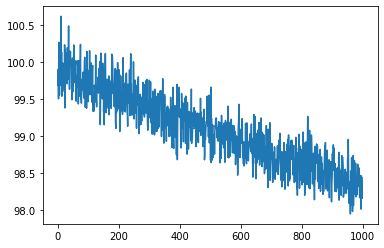

In [13]:
plt.plot(loss_curve)
plt.savefig("Checkpoints/CurveVel-A/multisource/UPFWI_e_1000.png")

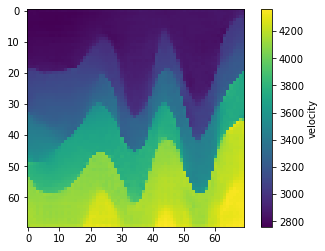

In [23]:
amp = total_amp_data[40:60]

pred_vel = net(amp)

# vel = vel[15,0,:]
first_vel = pred_vel[15,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/CurveVel-A/multisource/UPFWI_e_1000_40_60_prediction.png")
plt.show()

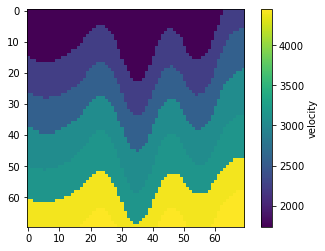

In [19]:
vel = total_vel_data[0:50]
vel = vel.detach().cpu().numpy()
plt.imshow(vel[15,0,:])
plt.colorbar(label='velocity')
# plt.savefig("Checkpoints/CurveVel-A/multisource/UPFWI_0_50_true.png")
plt.show()

In [22]:
naive_model = InversionNetB(input_channels, encoder_channels, decoder_channels).to(device)
# net.load_state_dict(torch.load('./Checkpoints/CurveVel-A/CurveVel-A_l_MSE_e_2000_no_parallel.pth'))
naive_model.load_state_dict(torch.load('./Checkpoints/CurveVel-A/Copy_1_InversionNet_e_2000.pth'))
naive_model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

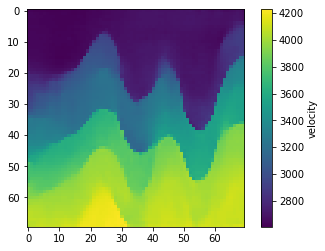

In [73]:
amp = total_amp_data[40:60]

pred_vel = naive_model(amp)

# vel = vel[15,0,:]
first_vel = pred_vel[15,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

# plt.savefig("Checkpoints/CurveVel-A/multisource/InversionNet_40_60_prediction.png")
plt.show()

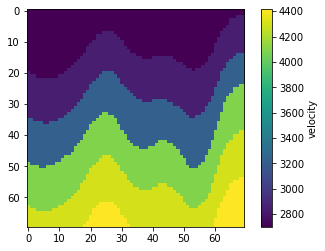

In [74]:
vel = total_vel_data[40:60]
vel = vel.detach().cpu().numpy()
plt.imshow(vel[15,0,:])
plt.colorbar(label='velocity')
# plt.savefig("Checkpoints/CurveVel-A/multisource/InversionNet_10_40_true.png")
plt.show()

## Loading model for inference

In [4]:
# Loading Model for Inference
model=InversionNetB(input_channels, encoder_channels, decoder_channels) #.type(dtype).to(device)
model.load_state_dict(torch.load('Checkpoints/CurveVel-A/multisource/Final_M2_UPFWI_e_1000_SGD.pth'))
model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

/tmp/ipykernel_73535/604546508.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
/tmp/ipykernel_73535/604546508.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()


Mean Absolute Error (MAE):  60.68712
Mean Relative Error (MRE):  0.021812685

Prediction


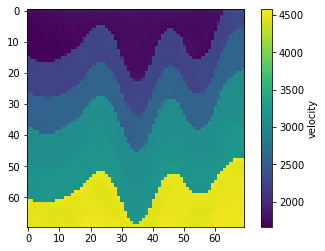

Ground Truth


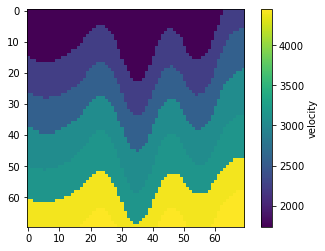

In [12]:
# Evaluation metrics - MAE and MRE
# with e=1000
amp = total_amp_data[0:]
vel = total_vel_data[0:]
pred_vel = model(amp.to('cpu'))

mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
print("Mean Absolute Error (MAE): ", mae)
print("Mean Relative Error (MRE): ", mre)
print("")
vel = vel[15,0,:]
pred_vel = pred_vel[15,0,:]

print("Prediction")
pred_vel = pred_vel.detach().cpu().numpy()
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

print("Ground Truth")
true_vel = vel.detach().cpu().numpy()
plt.imshow(true_vel)
plt.colorbar(label='velocity')
plt.show()

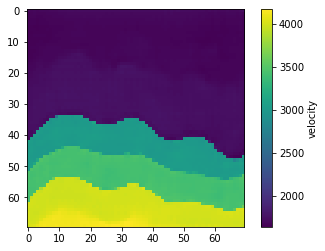

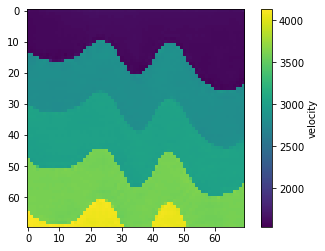

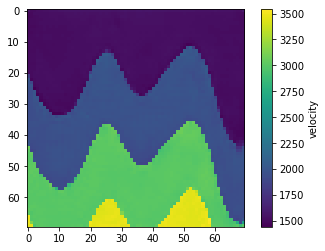

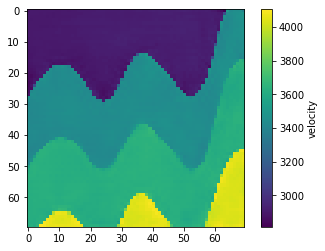

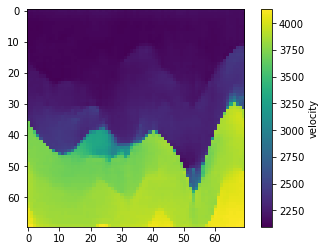

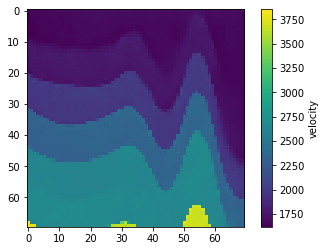

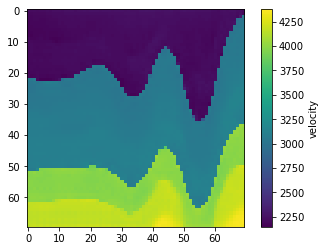

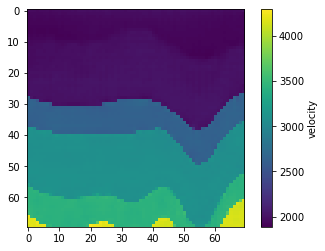

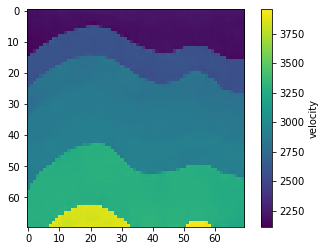

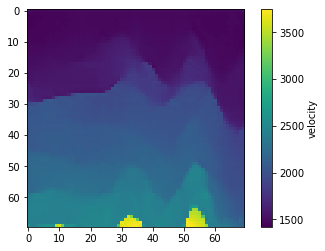

In [12]:
pred_amp= total_amp_data[0:50]

pred_vel = net(pred_amp)

# vel = vel[15,0,:]
for i in range(10):
    first_vel = pred_vel[i,0,:]

    vel_np = first_vel.detach().cpu().numpy()

    plt.imshow(vel_np)
    plt.colorbar(label='velocity')
    plt.show()

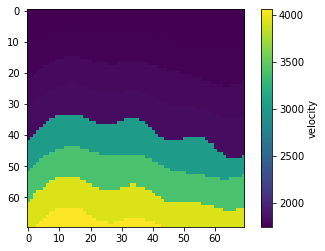

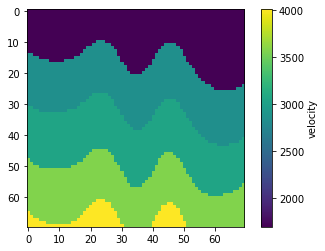

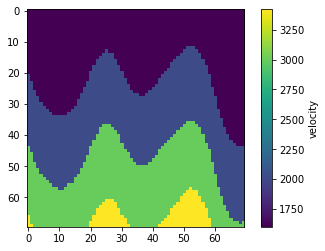

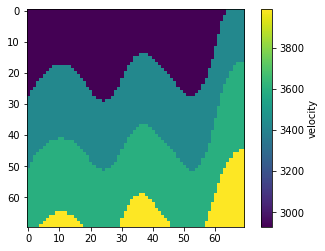

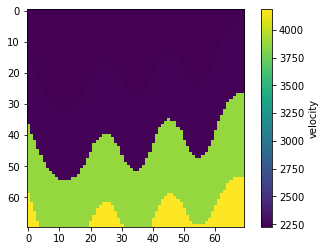

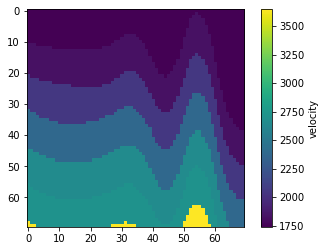

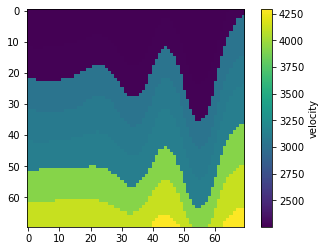

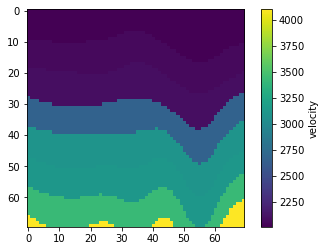

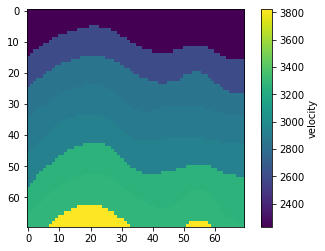

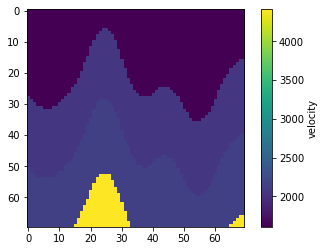

In [13]:
vel_true = total_vel_data[0:10]

for i in range(10):
    first_vel = vel_true[i,0,:]

    vel_np = first_vel.detach().cpu().numpy()

    plt.imshow(vel_np)
    plt.colorbar(label='velocity')
    plt.show()

## Multisource model M2 on Marmousi Data

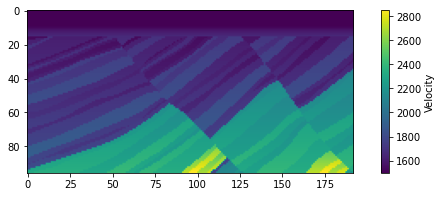

In [5]:
# Loading marmousi data
vp_true, vp_init, m, d = marmousi2(origin=(7500, 355), 
                        size=(1910, 950), 
                        pixel_scale="small",
                        initial_model_style="gradient",
                        initial_config={'min':1500.0,'max':3000.0})

# To load full model
# vp_true, vp_init, m, d = marmousi2(patch='mini_square',pixel_scale='mini')


plot_shape = m.shape(as_grid=True)
vp_true_np = vp_true.reshape(plot_shape).T
# vp_init_np = vp_init.reshape(plot_shape).T

fig1 = plt.figure(figsize=(10,3))

# Used when full marmousi model is taken at pixel_scale = mini
# vp_true = np.pad(vp_true, ((40,40),(86,87)), mode = 'reflect')
# vp_init = np.pad(vp_init, ((40,40),(86,87)), mode = 'reflect')

#Changing to tensor
vp_true_var = torch.tensor(vp_true_np)
model_true = vp_true_var.clone().to(device)
model_true_var = model_true[None,None,...].type(dtype)
model_true_var = model_true_var.to(device)

vmin_true = torch.min(model_true_var)
vmax_true = torch.max(model_true_var)

vp_init_np = scipy.ndimage.gaussian_filter(model_true_var.cpu().detach().numpy(),
                                           sigma=15).squeeze()

#model_true_var = (model_true_var - vmin_true)/(vmax_true - vmin_true)

plt.imshow(model_true_var.detach().cpu().numpy().squeeze())
plt.colorbar(label='Velocity')
#plt.clim(1000,3000)

vp_init = torch.tensor(vp_init_np)
model_init = vp_init.clone()

In [6]:
# Model setup for DeepWave
dx = m.deltas[0]
nz, ny = vp_true_np.shape
num_dims = 2

# acquisition setup
num_shots = 20

num_sources_per_shot = 1
source_spacing = ny*dx / num_shots #10.0

num_receivers_per_shot = 96
receiver_spacing = ny*dx / num_receivers_per_shot #10.0

peak_freq = 10
dt = 0.004 # 4ms

n_seconds = 4
nt = int(n_seconds / dt)

In [7]:
#Build acquisition data

# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing

# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [8]:
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_true = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), 
                                dt).cpu()

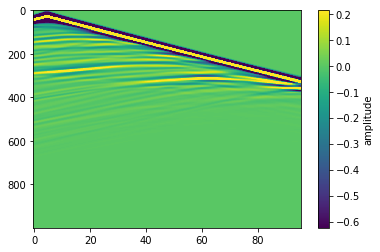

In [9]:
# Plot one shot gather
vmin, vmax = np.percentile(receiver_amplitudes_true[:,1].cpu().numpy(), [2,98])
plt.imshow(receiver_amplitudes_true[:,1].cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')

In [10]:
# Loading Model for Inference
model=InversionNetB(input_channels, encoder_channels, decoder_channels) #.type(dtype).to(device)
model.load_state_dict(torch.load('Checkpoints/CurveVel-A/multisource/Final_M2_UPFWI_e_1000_SGD.pth'))
model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

In [11]:
receiver_amplitudes_true = receiver_amplitudes_true.permute(1,0,2)
receiver_amplitudes_true.shape

torch.Size([20, 1000, 96])

In [12]:
receiver_amplitudes_true[:5,:].shape

torch.Size([5, 1000, 96])

Prediction


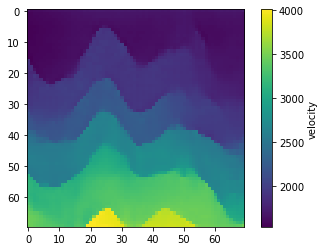

Ground Truth


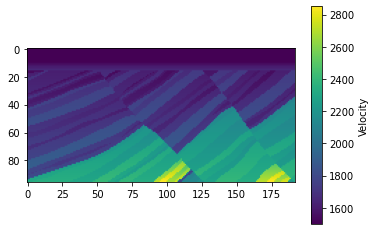

In [13]:
pred_vel = model(receiver_amplitudes_true[None,0:5,:, 0:70])

print("Prediction")
pred_vel = pred_vel.detach().cpu().numpy().squeeze()
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

print("Ground Truth")
plt.imshow(model_true_var.detach().cpu().numpy().squeeze())
plt.colorbar(label='Velocity')

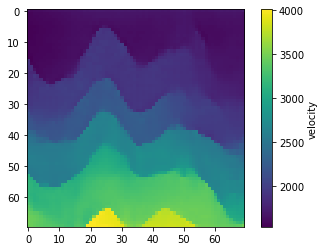

In [17]:
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

In [14]:
model_true_var = model_true_var.squeeze()
model_true_var = model_true_var[:70,:70]
mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
print("Mean Absolute Error (MAE): ", mae)
print("Mean Relative Error (MRE): ", mre)

Mean Absolute Error (MAE):  691.62823
Mean Relative Error (MRE):  0.40526992


/tmp/ipykernel_64146/4036193918.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
/tmp/ipykernel_64146/4036193918.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
